## UCL COMP0029 Individual Project for Year 3 BSc
### Robust Robotic Grasping Utilising Touch Sensing - Baseline Approach Notebook
This notebook contains the code for developing a baseline approach to grasping using classifiers: given some combinations of tactile data, end effector poses relative to the robot hand (visual data), etc., determine whether these constraints will produce a successful/unsuccessful grasp.

### 1. Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import gc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from math import sin, cos

import seaborn as sns

Set device for `PyTorch` training

In [2]:
# Use GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Empty PyTorch cache

In [3]:
gc.collect()
torch.cuda.empty_cache()

Set numpy seed

In [4]:
np.random.seed(seed=1)

### 2. Load datasets from saved .npy files

To collect data for this experiment, you can run the "Collect Sensory Data" button in the Pybullet simulation. This generates a predefined number of Gaussian grasps randomly generated from a base hand pose. Each individual grasp is considered as an individual experiment, and the data collected from this experiment is split into four, each stored in its own dataset.

For all object models used in this experiment, each object has 4 datasets which include:
- `depth_ds.npy` which stores the depth tactile data from the mounted DIGIT sensors
- `color_ds.npy` which stores the colored (RGB) version of the depth tactile data from the mounted DIGIT sensors
- `poses_ds.npy` which stores the randomly-generated 6d hand poses from the simulation
- `outcomes_ds.npy` which stores the outcomes of each random pose

In [5]:
root = "../datasets/"
# root = "../baseline_model/"
object_name = "block"      # object_name should be in [bottle, block, mug]

depth_data = np.load(root + object_name + "/depth_ds.npy")
color_data = np.load(root + object_name + "/color_ds.npy")
poses_data = np.load(root + object_name + "/poses_ds.npy")
grasp_outcomes_data = np.load(root + object_name + "/grasp_outcomes.npy")

These datasets should all be in the form of $(N\times...)$ where $N$ is the number of examples:

In [6]:
print(f"Shape of depth_data: {depth_data.shape}")
print(f"Shape of color_data: {color_data.shape}")
print(f"Shape of poses_data: {poses_data.shape}")
print(f"Shape of grasp_outcomes_data: {grasp_outcomes_data.shape}")

Shape of depth_data: (240, 2, 160, 120)
Shape of color_data: (240, 2, 160, 120, 3)
Shape of poses_data: (240, 6)
Shape of grasp_outcomes_data: (240,)


Additionally, we confirm the number of successful and unsuccessful grasps recorded. This helps us in the next section to determine how many examples we should include for each class in order to produce a balanced dataset.

In [7]:
print(f"# of sucessesful grasps: {(grasp_outcomes_data == 1).sum()}")
print(f"# of unsuccessful grasps: {(grasp_outcomes_data == 0).sum()}")

# of sucessesful grasps: 120
# of unsuccessful grasps: 120


### 3. Data preprocessing

We will train a logistic regression classifier on 3 combinations of data:
- **Tactile** only: concatenated and flattened depth and color data
- **Visual** only: 6D end effector poses consisting of position (x,y,z) and orientation (r,p,y) data
- **Both**: concatenated and flattened tactile and visual data

We define some reusable functions for later:

In [8]:
def normalize(arr):
    # Normalize & standardize each column
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    
    arr = (arr - mean) / std
    arr = np.nan_to_num(arr, 0)
    arr[np.isinf(arr)] = 0
    return arr

Since each tactile reading (depth and color) is a pair of images (one on each finger), we concatenate them together as a single 160x240 image.

In [9]:
depth_data = np.concatenate((depth_data[:, 0], depth_data[:, 1]), axis=2)
color_data = np.concatenate((color_data[:, 0], color_data[:, 1]), axis=2)
print(f"Shape of depth_data: {depth_data.shape}")
print(f"Shape of color_data: {color_data.shape}")

depth_ds = torch.from_numpy(normalize(depth_data))
color_ds = torch.from_numpy(normalize(color_data))
visual_ds = torch.from_numpy(np.nan_to_num(normalize(poses_data)))
visual_ds

Shape of depth_data: (240, 160, 240)
Shape of color_data: (240, 160, 240, 3)


C:\Users\Justin\AppData\Local\Temp\ipykernel_4080\218299750.py:6: RuntimeWarning: invalid value encountered in true_divide
  arr = (arr - mean) / std


tensor([[ 0.2785, -0.9659, -0.4598,  0.0000, -0.4935,  0.7216],
        [ 0.4918, -1.0686,  0.3301,  0.0000,  1.0465,  0.8830],
        [ 1.2918, -1.1100,  0.3876,  0.0000, -0.5295, -1.2266],
        ...,
        [-0.1925,  1.2981, -0.5058,  0.0000,  1.4517,  1.2078],
        [-1.5154,  1.4382,  1.1259,  0.0000,  0.9783, -0.6969],
        [-1.3056,  0.9158, -1.4146,  0.0000, -0.4852,  0.5514]],
       dtype=torch.float64)

We then concatenate the depth and color datasets to produce the flattened tactile dataset:

In [10]:
tactile_ds = torch.cat([depth_ds.unsqueeze(-1), color_ds], dim=-1)
tactile_ds = torch.nan_to_num(tactile_ds)
complete_ds = torch.cat([tactile_ds.reshape(tactile_ds.shape[0], -1), visual_ds], dim=1)
complete_ds = torch.nan_to_num(complete_ds)
tactile_ds.shape, complete_ds.shape

(torch.Size([240, 160, 240, 4]), torch.Size([240, 153606]))

### 4. Dataset visualisation (optional)

Only run this section to produce figures and plots for the project report.

In [11]:
Z_PADDING = 0.2        # Adjust for visualisation of end poses


def plot_ee_pose(pose_data, grasp_outcome, ax, orientation):
    x, y, z, alpha, beta, gamma = pose_data
    z -= Z_PADDING * 1.6

    # create rotation matrix based on Euler angles
    Rx = np.array([[1, 0, 0], [0, cos(alpha), sin(alpha)], [0, -sin(alpha), cos(alpha)]])
    Ry = np.array([[cos(beta), 0, -sin(beta)], [0, 1, 0], [sin(beta), 0, cos(beta)]])
    Rz = np.array([[cos(gamma), sin(gamma), 0], [-sin(gamma), cos(gamma), 0], [0, 0, 1]])
    R = Rz.dot(Ry.dot(Rx))

    # calculate endpoints of line based on orientation
    vec = np.array([0, 0.015, 0])
    vec_rotated1 = R.dot(vec)
    endpoint1 = [x + vec_rotated1[0], y + vec_rotated1[1], z + vec_rotated1[2]]
    
    vec_rotated2 = R.dot(-vec)
    endpoint2 = [x + vec_rotated2[0], y + vec_rotated2[1], z + vec_rotated2[2]]

    # set midpoint to the actual point
    midpoint = [x, y, z]

    # plot line through point in orientation direction
    ax.plot([endpoint1[0], endpoint2[0]], [endpoint1[1], endpoint2[1]], [endpoint1[2], endpoint2[2]], color='green' if grasp_outcome==1 else 'red', zorder=20)

    # plot vertical lines starting from endpoints
    ax.plot([endpoint1[0], endpoint1[0]], [endpoint1[1], endpoint1[1]], [endpoint1[2], endpoint1[2]-0.035], color='green' if grasp_outcome==1 else 'red', zorder=20)
    ax.plot([endpoint2[0], endpoint2[0]], [endpoint2[1], endpoint2[1]], [endpoint2[2], endpoint2[2]-0.035], color='green' if grasp_outcome==1 else 'red', zorder=20)

    # Display plot viewing orientation
    ax.view_init(elev=orientation[0], azim=orientation[1], roll=orientation[2])


# Draw block object
def plot_3d_box(ax, orientation):
    # Dimensions of the box object: (W=0.025, H=0.05, D=0.05)
    # Dimensions for unit box: (0,0,0), (0,1,0), (1,0,0), (0,0,1)
    cube_definition = [(-0.0125, -0.025, 0), (0.0125, -0.025, 0), (-0.0125, 0.0255, 0), (-0.0125, -0.025, 0.05)]
    cube_definition_array = [np.array(list(item)) for item in cube_definition]
    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]
    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]
    points = np.array(points)
    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k')
    faces.set_facecolor((0,0,1,0.1))
    faces.set_zorder(3)
    ax.add_collection3d(faces)
    # Plot the points themselves to force the scaling of the axes
    ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,2], s=0)
    ax.set_aspect('equal')
    ax.view_init(elev=orientation[0], azim=orientation[1], roll=orientation[2])

#### 4a. Visualise tactile and visual data for 1 successful and 1 unsuccessful grasp

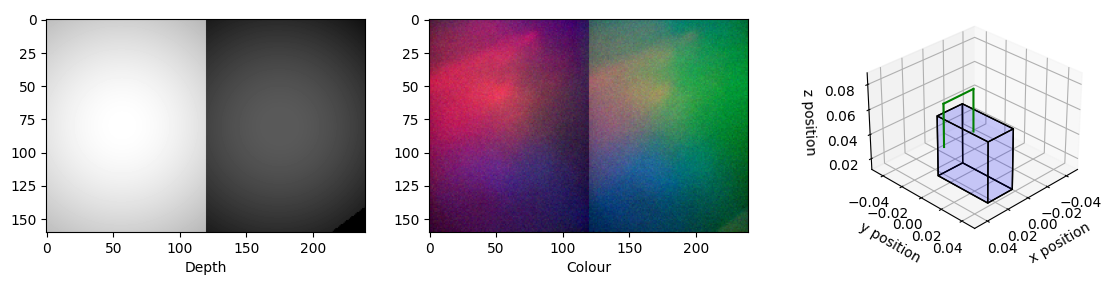

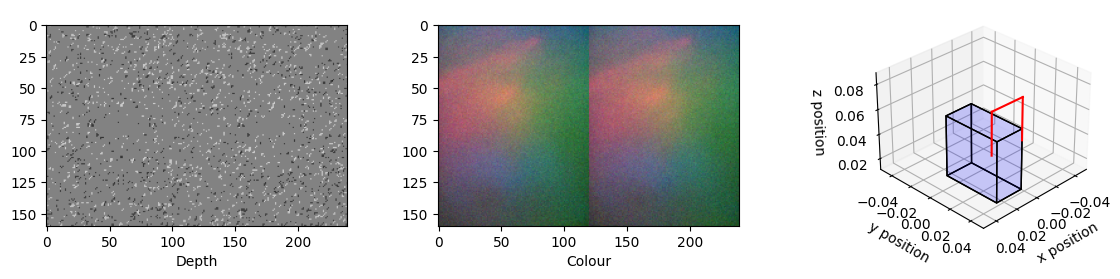

In [12]:
successful_grasps = np.where(grasp_outcomes_data == 1)[0]
unsuccessful_grasps = np.where(grasp_outcomes_data == 0)[0]

# Randomly select one index from each set
successful_rand_idx = np.random.choice(successful_grasps)
unsuccessful_rand_idx = np.random.choice(unsuccessful_grasps)

rand_indices = np.array([successful_rand_idx, unsuccessful_rand_idx])


# Note that the plots use the "..._data" datasets instead of the "..._ds" datasets since 
# the "..._ds" datasets are already flattened for training
for i in range(2):
    fig = plt.figure(figsize=(14, 3))
    # fig.suptitle("Successful grasp" if grasp_outcomes_data[rand_indices[i]].item() == 1.0 else "Unsuccessful grasp")
    
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_xlabel("Depth")
    ax1.imshow(np.array(depth_data[rand_indices[i]]), cmap='gray')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_xlabel("Colour")
    ax2.imshow(np.array(color_data[rand_indices[i]]) / 255., cmap='gray')
    
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.set_xlabel('x position')
    ax3.set_ylabel('y position')
    ax3.set_zlabel('z position')
    ax3.set_xlim3d(-0.05, 0.05)
    ax3.set_ylim3d(-0.05, 0.05)
    ax3.set_zlim3d(0, 0.1)

    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    pose_data = poses_data[rand_indices]
    plot_ee_pose(pose_data=poses_data[rand_indices[i]], grasp_outcome=grasp_outcomes_data[rand_indices[i]], ax=ax3, orientation=(30, 45, 0))
    plot_3d_box(ax3, orientation=(30, 45, 0))

fig.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

#### 4b. Visualise all end effector poses on box as skeleton hands

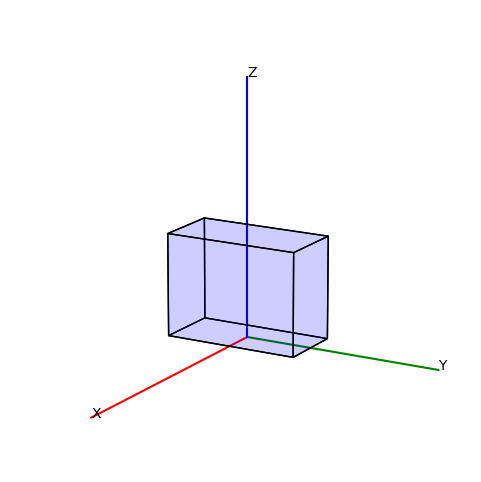

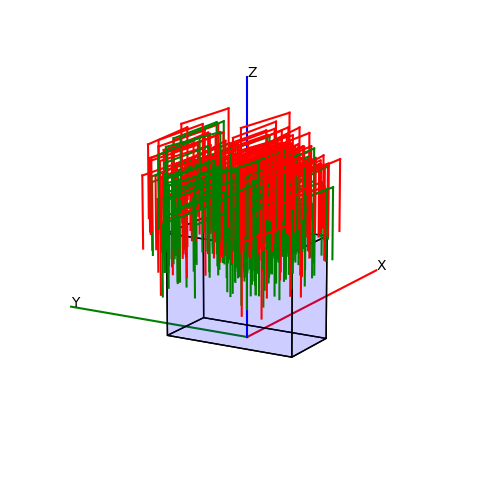

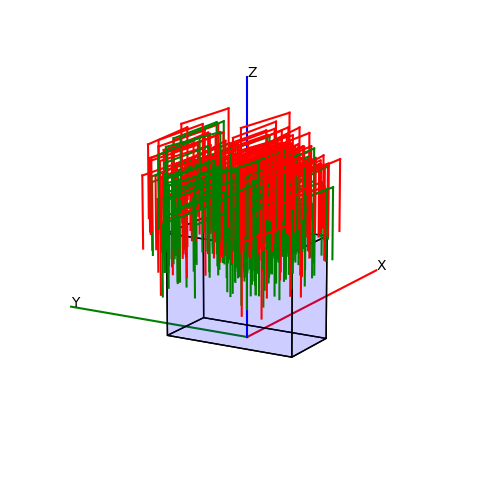

In [13]:
# Create 3 plots: 1 with the box only, remaining 2 with all poses each at different viewing orientations
for i in range(3):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
    
    # Plot unit vectors
    x_unit = np.array([0.1, 0, 0])
    y_unit = np.array([0, 0.075, 0])
    z_unit = np.array([0, 0, 0.125])
    ax.plot([0, x_unit[0]], [0, x_unit[1]], [0, x_unit[2]], color='r')
    ax.plot([0, y_unit[0]], [0, y_unit[1]], [0, y_unit[2]], color='g')
    ax.plot([0, z_unit[0]], [0, z_unit[1]], [0, z_unit[2]], color='b')

    ax.text(x_unit[0], x_unit[1], x_unit[2], 'X')
    ax.text(y_unit[0], y_unit[1], y_unit[2], 'Y')
    ax.text(z_unit[0], z_unit[1], z_unit[2], 'Z')

    # Remove all the axis and their labels
    ax.axis('off')
    ax.set_aspect('equal')
    plot_3d_box(ax, orientation=(15, 30, 0))
    if i == 0:
        ax.set_xlim3d(-0.05, 0.05)
        ax.set_ylim3d(-0.05, 0.05)
        ax.set_zlim3d(0, 0.1)
    if i > 0:
        ax.set_xlim3d(-0.05, 0.05)
        ax.set_ylim3d(-0.05, 0.05)
        ax.set_zlim3d(0, 0.1)
        for i in range(poses_data.shape[0]):
            plot_ee_pose(pose_data=poses_data[i], grasp_outcome=grasp_outcomes_data[i], ax=ax, orientation=(15, 30+90*(i-1), 0))

### 5. Model training

We now train our Logistic Regression models on the 3 combinations of our data (tactile, visual, both):
- Raw data
- Principal Component Analysis - 2 main components
- Convolutional Neural Network processed data

#### Prepare training and testing datasets

In [36]:
X_tactile_train, X_tactile_test, y_tactile_train, y_tactile_test = train_test_split(tactile_ds.reshape(tactile_ds.shape[0], -1), grasp_outcomes_data, test_size=0.2, random_state=0)
X_visual_train, X_visual_test, y_visual_train, y_visual_test = train_test_split(visual_ds, grasp_outcomes_data, test_size=0.2, random_state=0)
X_complete_train, X_complete_test, y_complete_train, y_complete_test = train_test_split(complete_ds, grasp_outcomes_data, test_size=0.2, random_state=0)

### 5.1 Raw data

#### 5.1.1 Raw data (tactile only) + LR

In [37]:
model_511 = LogisticRegression(random_state=0, max_iter=1000)
model_511.fit(X_tactile_train, y_tactile_train)
model_511_predictions = model_511.predict(X_tactile_test)

#### 5.1.2 Raw data (visual only) + LR

In [38]:
model_512 = LogisticRegression(random_state=0, max_iter=1000)
model_512.fit(X_visual_train, y_visual_train)
model_512_predictions = model_512.predict(X_visual_test)

#### 5.1.3 Raw data (both) + LR

In [39]:
model_513 = LogisticRegression(random_state=0, max_iter=1000)
model_513.fit(X_complete_train, y_complete_train)
model_513_predictions = model_513.predict(X_complete_test)

### 5.3 CNN for dimensionality reduction

In [40]:
# A simple convolutional neural network that extracts features from an input tensor
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, x):
        # print(f"Input size: {x.shape}")
        x = self.conv1(x)
        # print(f"Shape after conv1: {x.shape}")
        x = nn.functional.relu(x)
        x = self.pool(x)
        # print(f"Shape after pool1: {x.shape}")

        x = self.conv2(x)
        # print(f"Shape after conv2: {x.shape}")
        x = nn.functional.relu(x)
        x = self.pool(x)
        # print(f"Shape after pool2: {x.shape}")
        
        x = self.conv3(x)
        # print(f"Shape after conv3: {x.shape}")
        x = nn.functional.relu(x)
        x = self.pool(x)
        # print(f"Shape after pool3: {x.shape}")

        return x

In [41]:
# Preprocess data using CNN feature extraction
cnn = FeatureExtractorCNN()
cnn_tactile = torch.cat([cnn(img.float().permute(2,0,1)).unsqueeze(0) for img in tactile_ds])
cnn_tactile = cnn_tactile.reshape(cnn_tactile.shape[0], -1)
cnn_tactile.shape

torch.Size([240, 19200])

In [42]:
# We simply combine the cnn-processed tactile data (from Section 5.3.1) with the visual data
cnn_complete_ds = torch.cat([cnn_tactile.reshape(cnn_tactile.shape[0], -1), visual_ds], dim=1)
cnn_complete_ds.shape

torch.Size([240, 19206])

In [43]:
X_cnn_tactile_train, X_cnn_tactile_test, y_cnn_tactile_train, y_cnn_tactile_test = train_test_split(cnn_tactile.detach().numpy(), grasp_outcomes_data, test_size=0.2, random_state=0)
X_cnn_complete_train, X_cnn_complete_test, y_cnn_complete_train, y_cnn_complete_test = train_test_split(cnn_complete_ds.detach().numpy(), grasp_outcomes_data, test_size=0.2, random_state=0)

#### 5.3.1 CNN (tactile only) + LR

In [44]:
model_531 = LogisticRegression(random_state=0, max_iter=1000)
model_531.fit(X_cnn_tactile_train, y_cnn_tactile_train)
model_531_predictions = model_531.predict(X_cnn_tactile_test)

#### 5.3.2 CNN (visual only) + LR

#### 5.3.3 CNN (both) + LR

In [45]:
model_533 = LogisticRegression(random_state=0, max_iter=1000)
model_533.fit(X_cnn_complete_train, y_cnn_complete_train)
model_533_predictions = model_533.predict(X_cnn_complete_test)

#### 5.3.4 CNN (tactile only) + PCA + LR

In [46]:
def pca(tensor, k, verbose=False):
    if len(tensor) == 3:
        tensor = tensor.reshape((tensor.shape[0], -1))
    
    pca = PCA(n_components=k)
    pca.fit(tensor)

    variance = sum(pca.explained_variance_ratio_) * 100
    # print(f"Variance captured for {k} components: {variance:.2f}%")

    if verbose:
        return pca.transform(tensor), k, variance
    else:
        return pca.transform(tensor)

We select $k$ principal components that correspond to 90% variance of the dataset.

In [47]:
K = 0

k_variances = []

In [48]:
for i in range(1, 30):
    pca_cnn_tactile_ds, k, variance = pca(cnn_tactile.detach().numpy(), k=i, verbose=True)
    k_variances.append(variance)
    if variance > 90:
        print(f"Choose {k} components for CNN + tactile only dataset.")
        K = k
        break

In [49]:
for k in range(0, K, 5):
    if k > 0:
        print(f"Variance for {k} components: {k_variances[k]:.2f}%")

Plot number of components against variance captured

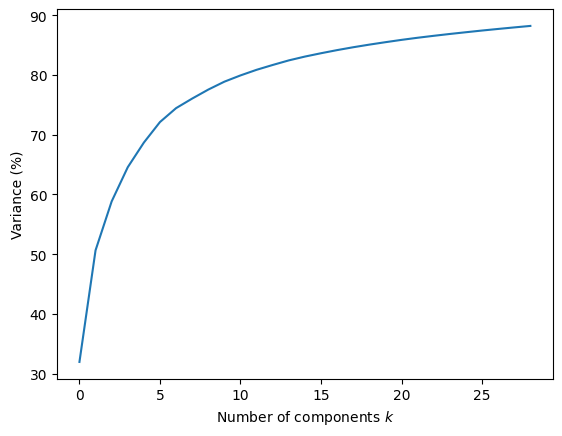

In [50]:
plt.plot(k_variances)
plt.xlabel('Number of components ' + r'$k$')
plt.ylabel('Variance (%)')
plt.show()

In [51]:
pca_cnn_tactile_ds = pca(cnn_tactile.detach().numpy(), k=5)
X_pca_cnn_tactile_train, X_pca_cnn_tactile_test, y_pca_cnn_tactile_train, y_pca_cnn_tactile_test = train_test_split(pca_cnn_tactile_ds, grasp_outcomes_data, test_size=0.2, random_state=0)
model_534 = LogisticRegression(random_state=0, max_iter=1000)
model_534.fit(X_pca_cnn_tactile_train, y_pca_cnn_tactile_train)
model_534_predictions = model_534.predict(X_pca_cnn_tactile_test)

In [52]:
pca_cnn_complete_ds = pca(cnn_complete_ds.detach().numpy(), k=5)
X_pca_cnn_complete_train, X_pca_cnn_complete_test, y_pca_cnn_complete_train, y_pca_cnn_complete_test = train_test_split(pca_cnn_complete_ds, grasp_outcomes_data, test_size=0.2, random_state=0)
model_535 = LogisticRegression(random_state=0, max_iter=1000)
model_535.fit(X_pca_cnn_complete_train, y_pca_cnn_complete_train)
model_535_predictions = model_535.predict(X_pca_cnn_complete_test)

### 5.4 Results

In [53]:
def plot_confusion_matrices(model_data, fig_height):
    fig, axn = plt.subplots(1, len(model_data), sharex=True, sharey=True, figsize=(12, fig_height))

    for i, ax in enumerate(axn.flat):
        try:
            model_name = list(model_data.keys())[i]
            model = model_data[model_name]
            preds = model["preds"]
            score = model["score"]
            test_set = model["test_set"]

            if score is not None and preds is not None and test_set is not None:
                cm = confusion_matrix(test_set, preds)
                sns.heatmap(cm, linewidths=1, ax=ax, annot=True, fmt='g')
                ax.set_title(model_name + f": {score*100:.2f}%", fontsize=8)
            else:
                ax.set_title(model_name + "No results", fontsize=8)
            continue
        except IndexError:
            pass

In [54]:
model_data = {
    "Raw (tactile only)": {"score": model_511.score(X_tactile_test, y_tactile_test), "preds": model_511_predictions, "test_set": y_tactile_test},
    "Raw (visual only)": {"score": model_512.score(X_visual_test, y_visual_test), "preds": model_512_predictions, "test_set": y_visual_test},
    "Raw (both)": {"score": model_513.score(X_complete_test, y_complete_test),"preds": model_513_predictions,"test_set": y_complete_test},
}

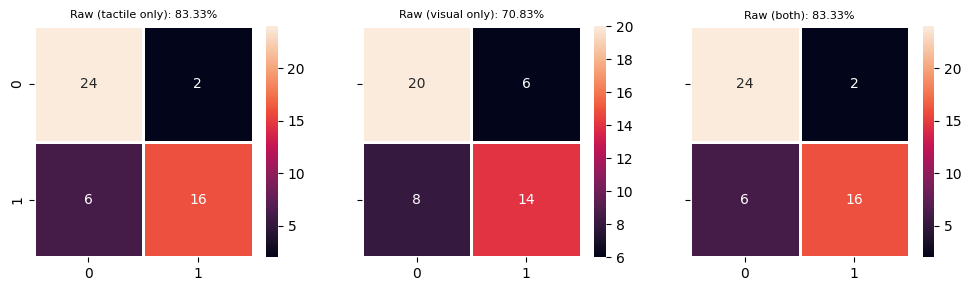

In [55]:
plot_confusion_matrices(model_data, fig_height=3)

In [56]:
model_data = {
    "CNN (tactile only)": {"score": model_531.score(X_cnn_tactile_test, y_cnn_tactile_test), "preds": model_531_predictions,"test_set": y_cnn_tactile_test},
    "CNN (both)": {"score": model_533.score(X_cnn_complete_test, y_cnn_complete_test), "preds": model_533_predictions, "test_set": y_cnn_complete_test},
    "CNN (tactile only) + PCA": {"score": model_534.score(X_pca_cnn_tactile_test, y_pca_cnn_tactile_test), "preds": model_534_predictions, "test_set": y_pca_cnn_tactile_test},
    "CNN (both) + PCA": {"score": model_535.score(X_pca_cnn_complete_test, y_pca_cnn_complete_test), "preds": model_535_predictions, "test_set": y_pca_cnn_complete_test}
}

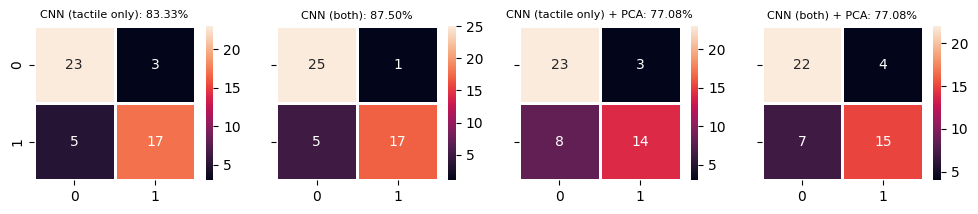

In [57]:
plot_confusion_matrices(model_data, fig_height=2)